In [ ]:
import json
import requests
import urllib

# 0. Preliminary step to get sample data



This preliminary step is reproducing Lorella's workflow Python file:
https://i-lab.public.data.uu.nl/vault-ocex/ChroniclItaly%20-%20Italian%20American%20newspapers%20corpus%20from%201898%20to%201920%5B1529330521%5D/original/
I just added a folder "data_1" to keep all files in one folder

In [ ]:
mkdir 'data1'

In [ ]:
# Base URL
chronam = 'https://chroniclingamerica.loc.gov/'

# Chronicling America search results
results = 'https://chroniclingamerica.loc.gov/search/pages/results/?date1=1880&date2=1920&searchType=advanced&language=ita&sequence=1&lccn=2012271201&lccn=sn85066408&lccn=sn85055164&lccn=sn85054967&lccn=sn88064299&lccn=sn84037024&lccn=sn84037025&lccn=sn86092310&proxdistance=5&state=California&state=District+of+Columbia&state=Massachusetts&state=Pennsylvania&state=Piedmont&state=Vermont&state=West+Virginia&rows=100&ortext=&proxtext=&phrasetext=&andtext=&dateFilterType=yearRange&page=11&sort=date'

# Count to keep track of downloaded files
count = 0

# Gets search results in JSON format
results_json = results + '&format=json'


In [ ]:
# Returns JSON 
def get_json(url):
    data = requests.get(url)
    return(json.loads(data.content))
    
data = get_json(results_json)

In [ ]:
files_list = []
# Cycle through JSON results
for page in data['items']:
    # Create URL
    hit = str(page['id'])
    seed = hit + 'ocr.txt'
    download_url = chronam + seed
 
    # Create file name
    file_name = download_url.replace('/', '_')
    files_list.append(file_name[41:])
    file_name = 'data1/' + file_name[41:]

    # Download .txt of the page
    urllib.request.urlretrieve(download_url, str(file_name))
    count += 1

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [ ]:
import os
import pandas as pd

In [ ]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [ ]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open('data1/' + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [ ]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

In [ ]:
# variable containing the documents separately
corpus = sources['file_content']

In [ ]:
# the 2 cells below shouldn't be useful anymore
# for verification purposes later, count the nr of characters for each content
#sources['file_len'] = sources['file_content'].apply(lambda x: len(x))
#sources['file_len'].sum()

In [ ]:

# variable containing all documents together
#all_texts = ''
#for i in range(len(sources)):
#all_texts += sources['file_content'][i]
# check length
#len(all_texts)

## 1.2 Removing stop words, punctuation, short words

In [ ]:
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
# add tokenized documents in dataframe
sources['tokens'] = sources['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [ ]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to removes all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
sources['doc_prep'] = sources['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 3 )])

In [ ]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')

In [ ]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [ ]:
# spacy list of Stop words (seems to be more complete than NLTK)
# import spacy
# from spacy.lang.it.stop_words import STOP_WORDS
# spacy_it_sw = STOP_WORDS

In [ ]:
# add column with tokenized documents without sw
sources['doc_prep_nostop'] = sources['doc_prep'].apply(lambda x: [w for w in x if not w in ital_stopwords])

## 1.3 Create bigrams

In [ ]:
import gensim

In [ ]:
bigram = gensim.models.Phrases(sources['doc_prep_nostop'], min_count=5, threshold=100)

In [ ]:
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
sources['bigrams'] = [bigram_mod[doc] for doc in sources['doc_prep_nostop']]

## 1.4 Lemmatize

In [ ]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [ ]:
%%capture
!python -m spacy download it_core_news_sm

In [ ]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [ ]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [ ]:
# add column with lemmatized tokens
sources['doc_lemmatized'] = sources['bigrams'].apply(lambda x: lemmatize(x))

In [ ]:
# variable with lemmatized tokens
lemmatized_corpus = sources['doc_lemmatized']

# 2. Topics with LDA

In [ ]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [ ]:
# dataset = [d.split() for d in lemmatized_corpus] (this is not useful if lemmatized version is used)
# Create Dictionary
# change "lemmatized_corpus" variable by stemmed_corpus or tokenized_corpus_without_sw depending
# on which version you would like to work with 
id2word = corpora.Dictionary(lemmatized_corpus)
corpus = [id2word.doc2bow(text) for text in lemmatized_corpus]

In [ ]:
# list of words and occurence per document
words = []
frequency = []

for cp in corpus:
  word_id = list(cp[0])[0]
  words.append(id2word[list(cp[0])[0]])
  frequency.append(list(cp[0])[1])

In [ ]:
words_frequency = pd.DataFrame(list(zip(words, frequency)), columns=['word', 'frequency'])

In [ ]:
# sort descending
# words_frequency.sort_values(by=['frequency'], ascending=False)[:10]

## 2.2 LDA

In [ ]:
# set the number of topics here
numtopics = 8

In [ ]:
ldagensim = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics, iterations = 400, chunksize = 2000, passes = 20)

In [ ]:
ldagensim.print_topics()

[(0,
  '0.004*"potere" + 0.003*"altro" + 0.003*"stare" + 0.002*"lavorare" + 0.002*"cosa" + 0.002*"tutto" + 0.002*"senza" + 0.002*"popolare" + 0.002*"vedere" + 0.002*"essi"'),
 (1,
  '0.005*"italiano" + 0.004*"stare" + 0.003*"nuovo" + 0.003*"roma" + 0.003*"primo" + 0.003*"fare" + 0.003*"dire" + 0.003*"altro" + 0.003*"potere" + 0.002*"cardinale"'),
 (2,
  '0.005*"stare" + 0.003*"potere" + 0.002*"terno" + 0.002*"governare" + 0.002*"altro" + 0.002*"partire" + 0.002*"fare" + 0.002*"leggere" + 0.002*"ogni" + 0.002*"tutto"'),
 (3,
  '0.005*"italiano" + 0.004*"stare" + 0.003*"italia" + 0.003*"altro" + 0.003*"grande" + 0.003*"fare" + 0.003*"roma" + 0.003*"dire" + 0.003*"venire" + 0.003*"molto"'),
 (4,
  '0.005*"italiano" + 0.004*"roma" + 0.004*"potere" + 0.003*"dovere" + 0.003*"stare" + 0.003*"nuovo" + 0.003*"italia" + 0.003*"fare" + 0.003*"dire" + 0.002*"primo"'),
 (5,
  '0.006*"italiano" + 0.005*"stare" + 0.004*"italia" + 0.004*"altro" + 0.004*"roma" + 0.004*"dire" + 0.003*"anno" + 0.003*"dis

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.2598166986682539


## 2.4 Coherence and number of topics

In [ ]:
#can take a long time to run
%%capture
topics_nr = []
coherence_values_gensim = []
for num_topics in range(2, 20):
  model = models.LdaModel(corpus, id2word=id2word, num_topics=num_topics, iterations = 400, chunksize = 2000, passes = 20)
  coherencemodel = CoherenceModel(model=model, texts=lemmatized_corpus, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [ ]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 2  has Coherence Value of 0.2405
Num Topics = 3  has Coherence Value of 0.2338
Num Topics = 4  has Coherence Value of 0.2393
Num Topics = 5  has Coherence Value of 0.2512
Num Topics = 6  has Coherence Value of 0.2557
Num Topics = 7  has Coherence Value of 0.2514
Num Topics = 8  has Coherence Value of 0.2681
Num Topics = 9  has Coherence Value of 0.27
Num Topics = 10  has Coherence Value of 0.2824
Num Topics = 11  has Coherence Value of 0.2675
Num Topics = 12  has Coherence Value of 0.2497
Num Topics = 13  has Coherence Value of 0.3057
Num Topics = 14  has Coherence Value of 0.2673
Num Topics = 15  has Coherence Value of 0.3106
Num Topics = 16  has Coherence Value of 0.2858
Num Topics = 17  has Coherence Value of 0.264
Num Topics = 18  has Coherence Value of 0.2979
Num Topics = 19  has Coherence Value of 0.2653


In [ ]:
# Visualize coherence scores
import matplotlib.pyplot as plt

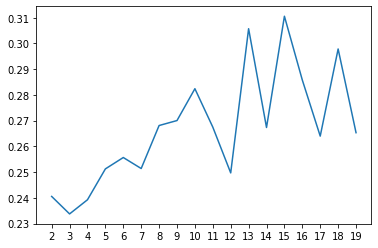

In [ ]:
plt.plot(topics_nr, coherence_values_gensim)

In [ ]:
# To analyse the results, the user can print the list of topics for different topic nr

In [ ]:
# print topics for nr of topics = 10
%%capture
numtopics = 10
model = models.LdaModel(corpus, id2word=id2word, num_topics=numtopics, iterations = 400, chunksize = 2000, passes = 20)

In [ ]:
model.print_topics()

[(0,
  '0.004*"fare" + 0.004*"italiano" + 0.003*"roma" + 0.003*"dire" + 0.003*"egli" + 0.003*"stare" + 0.003*"tutto" + 0.003*"altro" + 0.003*"governare" + 0.003*"italia"'),
 (1,
  '0.006*"italiano" + 0.003*"cardinale" + 0.003*"anno" + 0.003*"fare" + 0.003*"dire" + 0.003*"stare" + 0.003*"italia" + 0.003*"molto" + 0.002*"altro" + 0.002*"grande"'),
 (2,
  '0.004*"potere" + 0.004*"stare" + 0.003*"italiano" + 0.003*"nuovo" + 0.003*"primo" + 0.003*"altro" + 0.003*"dire" + 0.003*"italia" + 0.003*"fare" + 0.002*"grande"'),
 (3,
  '0.010*"cardinale" + 0.005*"conclave" + 0.004*"papa" + 0.003*"potere" + 0.003*"nome" + 0.003*"dopo" + 0.003*"quale" + 0.003*"primo" + 0.002*"terra" + 0.002*"dovere"'),
 (4,
  '0.006*"italiano" + 0.005*"stare" + 0.004*"roma" + 0.004*"altro" + 0.004*"potere" + 0.004*"italia" + 0.004*"dire" + 0.004*"fare" + 0.003*"anno" + 0.003*"venire"'),
 (5,
  '0.005*"stare" + 0.004*"italiano" + 0.004*"roma" + 0.004*"altro" + 0.004*"fare" + 0.003*"venire" + 0.003*"grande" + 0.003*"dop

# Topic visualisation

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_gensim.py

In [ ]:
# Number of terms to display stats for
R = 30

In [ ]:
%run -i tm1_gensim.py

<Figure size 640x480 with 0 Axes>

In [ ]:
%%capture
import notebook.nbextensions
notebook.nbextensions.install_nbextension('topic_info.csv', user=True)
notebook.nbextensions.install_nbextension('topic_proportion.csv', user=True)

In [ ]:
from IPython.display import display, HTML
from IPython.core.display import Javascript

In [ ]:
display(HTML('<style>@import url("https://fonts.googleapis.com/css2?family=Fira+Sans:wght@300&display=swap");#vis_tm_1{width:40%; margin-left:20%}.svg-container{position:relative;width:100%;vertical-align:top;overflow:hidden;margin:0;padding:0;}.svg-content-responsive{margin:0;padding:0;display:inline-block;position:absolute;top:0;left:0}.line_style{stroke:"rgb(70, 130, 180,.3)";stroke-width:1}.svg_h1{font-size:.9em}.svg_h1,.svg_h2{font-family:"Fira Sans",Arial}.svg_h2{font-size:.6em}.svg_text{font-size:.8em}.svg_text,.svg_text_2{font-family:"Fira Sans",Arial}.svg_text_2{font-size:.7em}.svg_text_3{font-family:"Fira Sans";font-size:.6em}.select_box{width:30%;padding-left:1em;font-family:"Fira Sans",Arial}.select_box select{width:100%;background-color:#fff;padding:.5em .6em;box-shadow:inset 0 1px 3px #ddd;vertical-align:middle;font-family:"Fira Sans",Arial,sans-serif;letter-spacing:.01em;line-height:1.15;-webkit-writing-mode:horizontal-tb!important;text-rendering:auto;color:#000;letter-spacing:normal;word-spacing:normal;text-transform:none;text-indent:0;text-shadow:none;display:inline-block;text-align:start;-webkit-appearance:menulist;align-items:center;white-space:pre;-webkit-rtl-ordering:logical;background-color:#f8f8f8;cursor:default;margin:0;font:400 11px system-ui;border-radius:5px;border:1px solid #a6a6a6;border-image:none;border-image:initial}.select_box select:focus{border-color:#fff;outline:0;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 1px rgba(102,175,233,.2)}</style>'))
display(HTML('<div id="vis_tm_1"></div>'))
Javascript(filename='jscode-test-2.js')

<IPython.core.display.Javascript object>

# Topic distribution

## 3.1. Distribution per topic and per document

In [ ]:
%%capture
ldamodel = model

In [ ]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [ ]:
distribution_gensim = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [ ]:
distribution_gensim.index.name = 'document'

In [ ]:
# add file names
distribution_gensim_wfiles = distribution_gensim.copy()
distribution_gensim_wfiles.insert(0, 'document_path', sources['file_name'])
distribution_gensim_wfiles

,document_path,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
document,,,,,,,,,,,
0,sn85066408_1903-04-27_ed-1_seq-1_ocr.txt,0.000065,0.000065,0.000065,0.000065,0.999418,0.000065,0.000065,0.000065,0.000065,0.000065
1,sn85066408_1903-04-28_ed-1_seq-1_ocr.txt,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.000058,0.999481
2,sn85066408_1903-04-29_ed-1_seq-1_ocr.txt,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.999310,0.000077
3,sn85066408_1903-04-30_ed-1_seq-1_ocr.txt,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.999242,0.000084
4,sn85066408_1903-05-01_ed-1_seq-1_ocr.txt,0.000124,0.998883,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124
...,...,...,...,...,...,...,...,...,...,...,...
95,sn85066408_1903-08-05_ed-1_seq-1_ocr.txt,0.000246,0.000246,0.000246,0.997783,0.000246,0.000246,0.000246,0.000246,0.000246,0.000246
96,sn85066408_1903-08-06_ed-1_seq-1_ocr.txt,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.999351
97,sn85066408_1903-08-07_ed-1_seq-1_ocr.txt,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.999431,0.000063,0.000063,0.000063


## 3.2. Distribution per topic for the whole corpus

In [ ]:
sources['doc_length'] = sources['doc_lemmatized'].apply(lambda x: len(x))

In [ ]:
topic_frequency = distribution_gensim.mul(sources['doc_length'], axis=0).sum()

In [ ]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [ ]:
topic_proportion

topic4    30.859210
topic9    15.914525
topic6     9.466103
topic2     9.428604
topic5     8.266509
topic8     6.748894
topic1     5.662316
topic0     4.887238
topic7     4.753507
topic3     4.013093
dtype: float64

In [ ]:
# dataframe with values to sort them by order of importance
distribution_df_gensim = pd.DataFrame(topic_proportion, columns=['weight'])

In [ ]:
distribution_df_gensim.index.name = "topics"

In [ ]:
topics = distribution_df_gensim.index.array

Text(0.5, 0, 'Weight (%)')

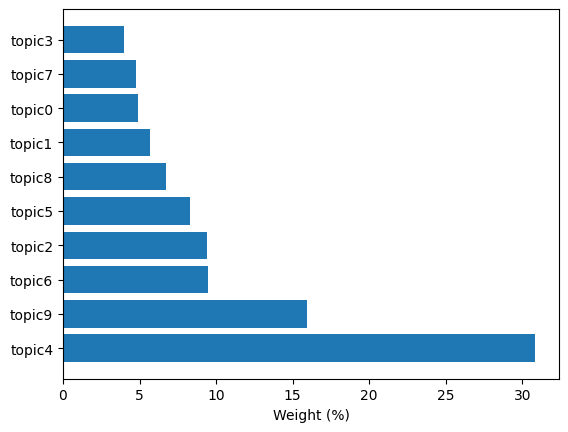

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df_gensim['weight'], align='center')
ax.set_xlabel('Weight (%)')

### 3.3. Distribution per publication


In [ ]:
import re
import seaborn as sns

In [ ]:
# function to retrieve publication ref from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

In [ ]:
distribution_gensim_wfiles['publication'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_ref(x))

In [ ]:
gensim_groupby2 = distribution_gensim_wfiles.copy()

In [ ]:
distribution_title = gensim_groupby2.groupby(['publication']).mean().reset_index()

In [ ]:
distribution_title

,publication,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,2012271201,0.103323,0.003442,0.303088,0.103318,0.103327,0.005316,0.003442,0.070108,0.003442,0.301195
1,sn85066408,0.047310,0.065762,0.072594,0.043259,0.325717,0.076533,0.105516,0.050800,0.071945,0.140564


In [ ]:
#restructuring df so that it can work with seaborn
df_vis2 = pd.DataFrame(columns=['publication', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_title.columns)-1
for i in range(len(distribution_title)):
  for j in range(columns_nr):
    df_vis2.loc[x] = ''
    df_vis2['publication'].loc[x] = distribution_title['publication'].loc[i]
    df_vis2['topic_id'].loc[x] = distribution_title.columns[j+1]
    df_vis2['distribution'].loc[x] = distribution_title.iloc[i,(j+1)]
    x+= 1

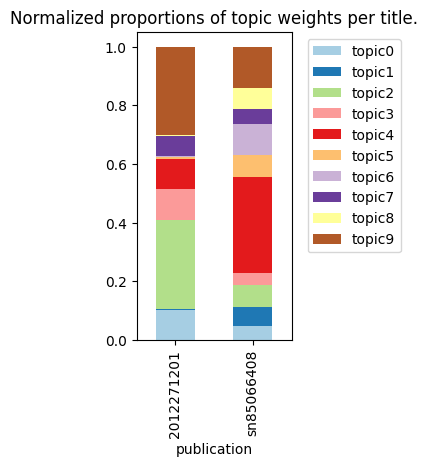

In [ ]:
df_vis2.pivot('publication','topic_id', 'distribution')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(2,4), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))

# Topics weight over time

## 4.1 Aggregate document weights

In [ ]:
# grouping data per month

In [ ]:
# function to retrieve date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# function to retrieve year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# function to retrieve month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

In [ ]:
distribution_gensim_wfiles['date'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_gensim_wfiles['year'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_gensim_wfiles['month'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_month(x))

In [ ]:
gensim_groupby = distribution_gensim_wfiles.copy()

In [ ]:
# drop columns that won't be needed at this stage
gensim_groupby = gensim_groupby.drop(['document_path', 'date'], axis=1)

In [ ]:
# group by year and month 
distribution_month = gensim_groupby.groupby(['year','month']).mean().reset_index()

In [ ]:
distribution_month

,year,month,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1903,04,0.000071,0.000071,0.000071,0.000071,0.249909,0.000071,0.000071,0.000071,0.499669,0.249927
1,1903,05,0.143713,0.073722,0.000073,0.000073,0.208692,0.087039,0.076953,0.115364,0.098913,0.195457
2,1903,06,0.050594,0.033385,0.188378,0.000073,0.271914,0.121499,0.056498,0.000073,0.063419,0.214167
3,1903,07,0.001149,0.097855,0.126127,0.101393,0.372521,0.033291,0.155954,0.073234,0.001149,0.037328
4,1903,08,0.000097,0.000097,0.000097,0.197660,0.468514,0.000097,0.111138,0.000097,0.000097,0.222106


## 4.2 Monthly average of normalized weight per topic

### 4.2.1. Line chart view 

In [ ]:
#restructuring df so that it can work with seaborn
df_vis = pd.DataFrame(columns=['time', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_month.columns)-2
for i in range(len(distribution_month)):
  for j in range(columns_nr):
    df_vis.loc[x] = ''
    df_vis['time'].loc[x] = distribution_month['month'].loc[i] + '/' + distribution_month['year'].loc[i]
    df_vis['topic_id'].loc[x] = distribution_month.columns[j+2]
    df_vis['distribution'].loc[x] = distribution_month.iloc[i,(j+2)]
    x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


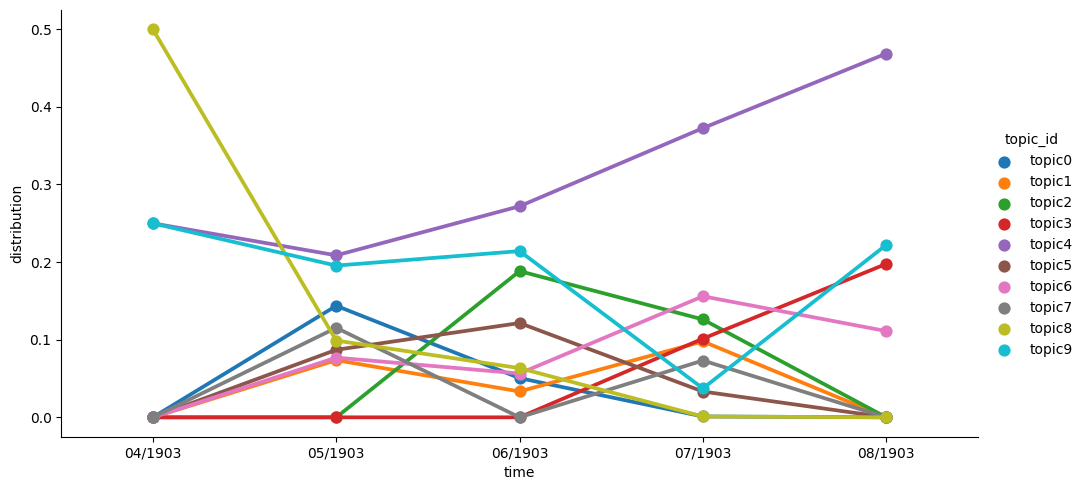

In [ ]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.2. Bar chart view

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


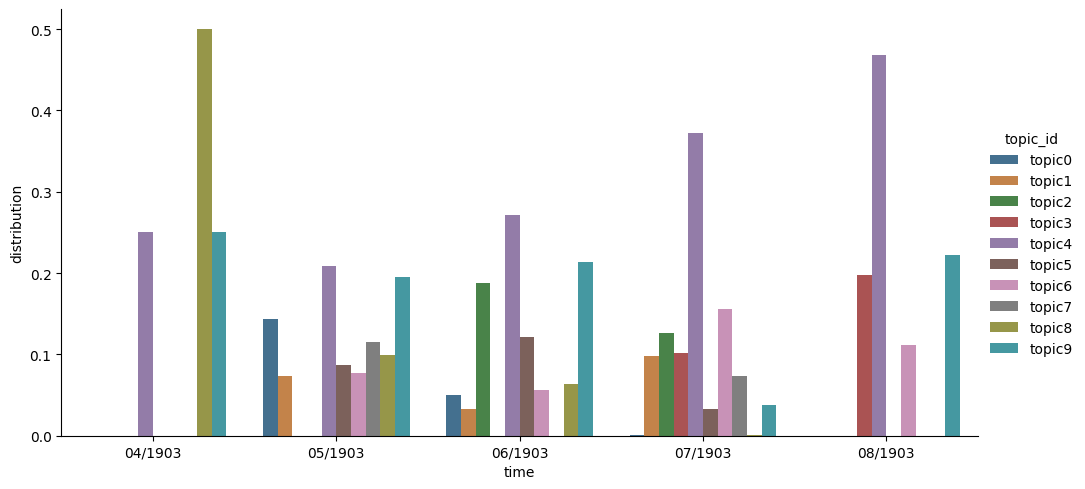

In [ ]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               kind= 'bar',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.3. Topic weights per title over time



In [ ]:
gensim_groupby3 = distribution_gensim_wfiles.copy()

In [ ]:
distribution_title_time = gensim_groupby3.groupby(['year','month','publication']).mean().reset_index()

In [ ]:
distribution_title_time

,year,month,publication,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1903,04,sn85066408,0.000071,0.000071,0.000071,0.000071,0.249909,0.000071,0.000071,0.000071,0.499669,0.249927
1,1903,05,sn85066408,0.143713,0.073722,0.000073,0.000073,0.208692,0.087039,0.076953,0.115364,0.098913,0.195457
2,1903,06,2012271201,0.249828,0.000125,0.499524,0.000125,0.000125,0.004810,0.000125,0.000125,0.000125,0.245088
3,1903,06,sn85066408,0.019942,0.038502,0.140509,0.000065,0.313728,0.139452,0.065171,0.000065,0.073156,0.209410
4,1903,07,2012271201,0.008421,0.008421,0.258137,0.258111,0.008421,0.008421,0.008421,0.175087,0.008421,0.258140
5,1903,07,sn85066408,0.000071,0.111105,0.106569,0.078176,0.426461,0.036975,0.177811,0.058145,0.000071,0.004615
6,1903,08,2012271201,0.000118,0.000118,0.000118,0.000118,0.499543,0.000118,0.000118,0.000118,0.000118,0.499517
7,1903,08,sn85066408,0.000091,0.000091,0.000091,0.254100,0.459649,0.000091,0.142858,0.000091,0.000091,0.142845


### 4.2.4. Rolling average

In [ ]:
distribution_month

,year,month,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,1903,04,0.000071,0.000071,0.000071,0.000071,0.249909,0.000071,0.000071,0.000071,0.499669,0.249927
1,1903,05,0.143713,0.073722,0.000073,0.000073,0.208692,0.087039,0.076953,0.115364,0.098913,0.195457
2,1903,06,0.050594,0.033385,0.188378,0.000073,0.271914,0.121499,0.056498,0.000073,0.063419,0.214167
3,1903,07,0.001149,0.097855,0.126127,0.101393,0.372521,0.033291,0.155954,0.073234,0.001149,0.037328
4,1903,08,0.000097,0.000097,0.000097,0.197660,0.468514,0.000097,0.111138,0.000097,0.000097,0.222106


In [ ]:
rolling_mean = distribution_month.rolling(2).mean()

In [ ]:
#restructuring df so that it can work with seaborn
df_vis3 = pd.DataFrame(columns=['time', 'topic_id', 'rolling_mean'])
x=0
columns_nr = len(rolling_mean.columns)-2
for i in range(len(rolling_mean)):
  for j in range(columns_nr):
    if ( rolling_mean.iloc[i,(j+2)] > 0 ):
      df_vis3.loc[x] = ''
      df_vis3['time'].loc[x] = "{} / {}".format(rolling_mean['month'].loc[i], distribution_month['year'].loc[i])
      df_vis3['topic_id'].loc[x] = rolling_mean.columns[j+2]
      df_vis3['rolling_mean'].loc[x] = rolling_mean.iloc[i,(j+2)]
      x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


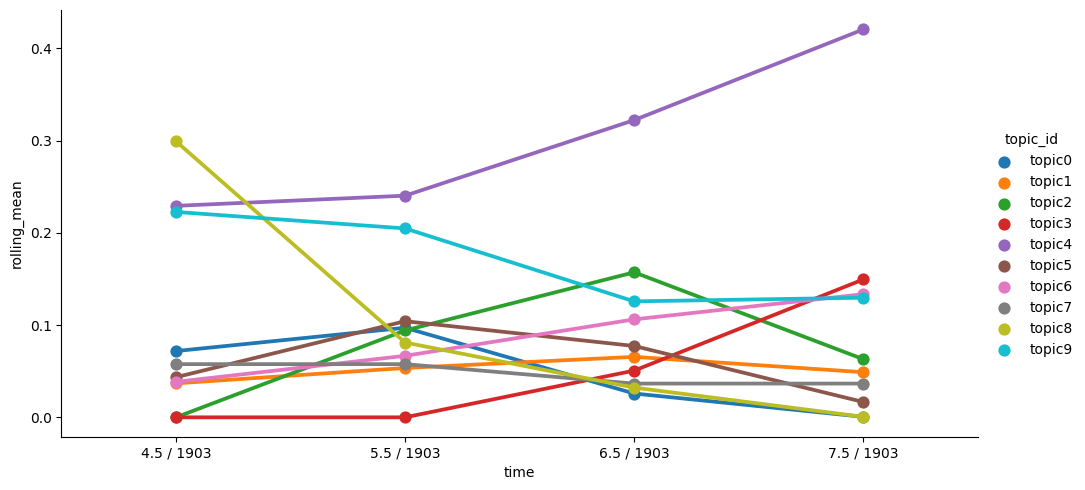

In [ ]:
sns.factorplot(data= df_vis3, 
               x= 'time',
               y= 'rolling_mean',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)